In [1]:
import re
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

Загрузим данные и изучим датасет

In [3]:
DATASET_PATH_TRAIN = './course_project_train.csv'
DATASET_PATH_TEST = './course_project_test.csv'

df = pd.read_csv(DATASET_PATH_TRAIN)
df_test = pd.read_csv(DATASET_PATH_TEST)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


<AxesSubplot:>

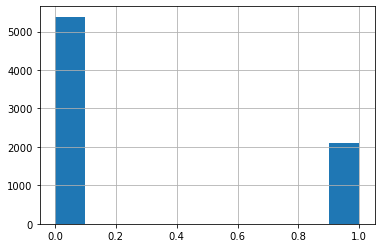

In [5]:
df['Credit Default'].hist()

Данные не сбалансированы, поэтому дополним датасет продублированными записями для класса 'Credit Default'=1. Далее разобьем данные на тренировочные и валидационные.

In [6]:
df = balance_df_by_target(df, 'Credit Default')

X = df.drop(columns='Credit Default')
y = df['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7690, 16), (1923, 16), (7690,), (1923,))

Подготовим данные: заполним пропуски и преобразуем данные.

In [7]:
class DataPreprocessing:    
    def __init__(self):
        self.medians = None
        self.convert_years = lambda s: int(re.sub(r'[^0-9]', '', s)) if isinstance(s, str) else np.NAN
        
    def fit(self, X, y=None):
        
        self.medians = X.median(numeric_only=True)
        self.medians['Years in current job'] = X['Years in current job'].apply(self.convert_years).median()
        
        if y is not None:
            pass
        return self
    
    def transform(self, X):
        """ Data transform """
        X = X.copy()
        
        X['Years in current job'] = X['Years in current job'].apply(self.convert_years)        
        #X.drop(columns=['Term', 'Tax Liens', 'Bankruptcies', 'Number of Credit Problems'], inplace=True)
        X.fillna(self.medians, inplace=True)
        return X

In [8]:
# Prepare data for processing
processor = DataPreprocessing().fit(X_train, y_train)

X_train1 = processor.transform(X_train)
X_test1 = processor.transform(X_test)

X_train1[X_train1.isnull().any(axis=1)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


Создадим класс модели и обучим модель на тренировочной выборке. Примерим модель к валидационным данным и оценим результат модели.

In [9]:
cat_features = [X_train1.columns.get_loc(name) for name in ['Home Ownership', 'Purpose', 'Term']]
model = catb.CatBoostClassifier(silent=True, random_state=21, cat_features=cat_features, l2_leaf_reg=2)

model.fit(X_train1, y_train)

y_train_predicted = model.predict(X_train1)
y_test_predicted = model.predict(X_test1)

get_classification_report(y_train, y_train_predicted, y_test, y_test_predicted)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4336
           1       0.93      0.84      0.89      3354

    accuracy                           0.90      7690
   macro avg       0.91      0.90      0.90      7690
weighted avg       0.91      0.90      0.90      7690

TEST

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1051
           1       0.81      0.69      0.74       872

    accuracy                           0.78      1923
   macro avg       0.79      0.78      0.78      1923
weighted avg       0.79      0.78      0.78      1923

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               908  143
1               272  600


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


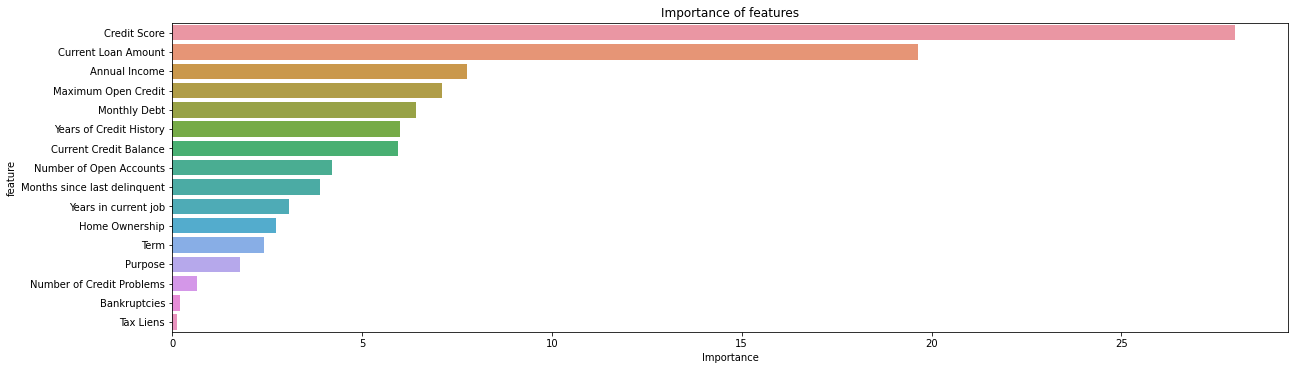

['Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Maximum Open Credit',
 'Monthly Debt',
 'Years of Credit History',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Years in current job',
 'Home Ownership',
 'Term',
 'Purpose',
 'Number of Credit Problems',
 'Bankruptcies']

In [10]:
show_feature_importances(X_train1.columns, model.feature_importances_, get_top=15)

Применим модель к проверочным данным.

In [11]:
# Apply final model to test data
df_test1 = processor.transform(df_test)
df_predict = model.predict(df_test1)
np.savetxt('out_result.csv', df_predict, delimiter=",")
df_predict

array([0, 0, 1, ..., 0, 0, 1])